In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection, multipletests
from itertools import combinations

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import seaborn as sns
from random import sample, seed

from unipressed import IdMappingClient
import time

### Results

In [5]:
df = pd.read_csv("tmp/protein_regressions.tsv", sep='\t')
df

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein
0,Intercept,0.045401,0.139,0.327307,0.743668,-0.227587,0.318389,297,3.665141e-02,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
1,maxscreeningconc,0.090802,0.277,0.327307,0.743668,-0.455174,0.636779,297,3.665141e-02,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
2,PdhbaiSRPbeHUMAN,0.344876,0.103,3.350153,0.000913,0.142280,0.547473,297,3.665141e-02,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
3,Intercept,0.312031,0.094,3.323116,0.001050,0.126929,0.497132,212,2.381952e-02,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
4,maxscreeningconc,0.624062,0.188,3.323116,0.001050,0.253858,0.994265,212,2.381952e-02,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11457382,Intercept,0.031738,0.006,5.078813,0.000004,0.019238,0.044238,62,8.588871e-02,0.805035,0.866990,0.293068,-0.176673,2510,62,16,Q96JM2.-7N462_HUMAN
11457383,maxscreeningconc,0.317376,0.062,5.078813,0.000004,0.192377,0.442375,62,8.588871e-02,0.805035,0.866990,0.293068,-0.176673,2510,62,16,Q96JM2.-7N462_HUMAN
11457384,QjgJMcZNegcHUMAN,0.482589,0.203,2.374347,0.020796,0.076026,0.889153,62,8.588871e-02,0.805035,0.866990,0.293068,-0.176673,2510,62,16,Q96JM2.-7N462_HUMAN
11457385,Intercept,0.045863,0.000,100.728627,0.000000,0.044969,0.046757,575,3.330669e-16,1.213866,1.147556,NaN,NaN,2510,575,149,DOSIS.


In [6]:
df_prot = df[df.coef_id.str.contains('HUMAN')].copy()

In [7]:
df_prot = df_prot.dropna()

In [8]:
alpha = 0.05
filter = 0.5

sig_proteins = []

drug_list = df_prot.drug.unique()

df_prot['p_corrected'] = 10.0

for d in drug_list:
    df_prot['p_corrected'][df_prot.drug == d] = multipletests(df_prot['P>|z|'][df_prot.drug == d], method='fdr_bh', alpha=alpha)[1]
    

C:\Users\wen068\AppData\Local\Temp\ipykernel_18904\3309065883.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prot['p_corrected'][df_prot.drug == d] = multipletests(df_prot['P>|z|'][df_prot.drug == d], method='fdr_bh', alpha=alpha)[1]


In [9]:
sig_proteins = df_prot[df_prot.p_corrected < alpha].copy()
sig_proteins.protein = sig_proteins.protein.str.split('.', expand=True)[0]

In [24]:
sig_proteins['gene_name'] = 'default'
prot_list = set(sig_proteins.protein)
print(len(prot_list))

request = IdMappingClient.submit(
    source="UniProtKB_AC-ID", dest="Gene_Name", ids=prot_list
)

6129


In [25]:
while True:
    status = request.get_status()
    if status in {"FINISHED", "ERROR"}:
        break
    else:
        time.sleep(5)

In [26]:
request.get_status()

'FINISHED'

In [27]:
result = list(request.each_result())
len(result)

5953

In [28]:
for dic in request.each_result():
    sig_proteins.gene_name[sig_proteins.protein == dic['from']] = dic['to']

C:\Users\wen068\AppData\Local\Temp\ipykernel_18904\762012980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_proteins.gene_name[sig_proteins.protein == dic['from']] = dic['to']


In [133]:
def undo(string):    
    string = ''.join([ x if ord(x)<91 else str(ord(x)-97) for x in string ])
    string = string[:6]+'.'+string[6:].replace('HUMAN', '_HUMAN') #not sure these 6
    return string

undo('QiWZAjIRGQHUMAN')

'Q8WZA9.IRGQ_HUMAN'

In [132]:
sig_proteins[(sig_proteins.gene_name == "default") & (sig_proteins.coef_id.str.contains('Z'))]

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein,p_corrected,gene_name
818,QiWZAjIRGQHUMAN,0.273057,0.065,4.203594,3.519891e-05,0.145199,0.400916,287,0.058381,1.003351,1.606445,0.241622,0.057681,1,287,73,Q8W-7A,6.977245e-03,default
1124,QhZgZhHUWEbHUMAN,0.291382,0.091,3.209735,1.475084e-03,0.112722,0.470042,297,0.033745,1.031341,1.582439,0.183698,0.217207,1,297,78,Q7-76-,4.668474e-02,default
1553,QjNZMbMYOFHUMAN,-0.164918,0.050,-3.298543,1.174881e-03,-0.263586,-0.066251,179,0.057911,1.221716,2.836745,0.240648,-0.022685,1,179,42,Q9N-7M,4.259737e-02,default
9398,QjNZdcARPbaHUMAN,0.440483,0.108,4.085955,7.927321e-05,0.227056,0.653909,123,0.121246,0.668106,1.581182,0.348205,-0.253252,1,123,35,Q9N-73,1.119421e-02,default
11522,QjHgZeRANBdHUMAN,0.323395,0.074,4.351587,1.879035e-05,0.177123,0.469668,290,0.061695,1.008635,1.656596,0.248384,-0.032890,1,290,76,Q9H6-7,5.176093e-03,default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11456133,QjGZZjUBAfHUMAN,-0.229093,0.093,-2.473721,1.385498e-02,-0.411250,-0.046937,345,0.017528,1.183198,0.926353,0.132393,0.296643,2510,345,99,Q9G-7-,3.838383e-02,default
11456343,QjBTZcDHRSeHUMAN,0.329688,0.060,5.467116,7.705748e-08,0.211166,0.448209,439,0.064018,1.108624,1.077362,0.253018,0.126277,2510,439,115,Q9BT-7,9.278674e-07,default
11456412,QfMIZhPeRdBHUMAN,-0.370124,0.141,-2.633098,9.574389e-03,-0.648435,-0.091813,122,0.054621,1.448166,0.995601,0.233711,-0.020231,2510,122,35,Q5MI-7,2.823961e-02,default
11456799,QiIZfcCHSScHUMAN,0.405930,0.153,2.647123,1.114936e-02,0.097072,0.714788,47,0.134736,0.975438,1.659611,0.367064,-0.256745,2510,47,18,Q8I-75,3.204343e-02,default


In [31]:
sig_proteins.to_csv("tmp/sig_protein_results.tsv", sep='\t', index=False)

In [80]:
drug_df = pd.read_csv('data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv', usecols=['drug_id','putative_target', 'putative_gene_target', 'target_pathway']).drop_duplicates(ignore_index=True)
drug_df = drug_df.set_index('drug_id').dropna()
drug_df

,putative_target,putative_gene_target,target_pathway
drug_id,,,
1409,EG5,KIF11,Mitosis
1057,"PI3K (class 1), MTORC1, MTORC2",PIK3CA;PIK3CB;PIK3CD;PIK3CG;MTOR,PI3K/MTOR signaling
1060,"MEK1, MEK2",MAP2K1;MAP2K2,ERK MAPK signaling
252,"SRC, ROCK2, NTRK2, FLT3, IRAK1, others",FLT3;IRAK1;NTRK2;ROCK2;SRC,Other
282,EGFR,EGFR,EGFR signaling
...,...,...,...
1554,CENPE,CENPE,Cytoskeleton
1545,TOP1,TOP1,DNA replication
2265,TGFBR1,TGFBR1,RTK signaling


In [81]:
drug_df.putative_target = drug_df.putative_target.astype('string')

In [34]:
prot_1 = sig_proteins[sig_proteins.drug==1].copy()

In [35]:
prot_1.sort_values(['p_corrected', 'pearsonR'], axis=0, ascending = [True, False], inplace=True)
prot_1.protein = prot_1.protein.str.split('.', expand=True)[0]
prot_1.head(10)

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein,p_corrected,gene_name
221,QjjhddNPbLeHUMAN,0.358048,0.072,4.980131,1.083336e-06,0.216555,0.499540,297,0.077553,0.984582,1.781332,0.278484,0.224002,1,297,79,Q99733,0.001182,NAP1L4
2423,PaibjfeFcHUMAN,-0.277105,0.053,-5.210697,3.540336e-07,-0.381765,-0.172445,297,0.084281,0.977401,1.775057,0.290313,0.223374,1,297,79,P08195,0.001182,SLC3A2
7733,PdgfedVATEbHUMAN,0.441868,0.089,4.938940,1.321885e-06,0.265790,0.617945,295,0.076855,0.991357,1.762081,0.277227,0.210437,1,295,76,P36543,0.001182,ATP6V1E1
5531,PdigagVATAHUMAN,0.454551,0.089,5.099431,6.103278e-07,0.279125,0.629977,297,0.081009,0.980893,1.824731,0.284621,0.178305,1,297,79,P38606,0.001182,ATP6V1A
8105,QjHaCiILKAPHUMAN,0.398332,0.080,4.979152,1.120334e-06,0.240852,0.555813,281,0.081608,0.976056,1.617942,0.285672,0.079667,1,281,74,Q9H0C8,0.001182,ILKAP
3290,QahbfhZObHUMAN,-0.498688,0.098,-5.108543,7.703903e-07,-0.691212,-0.306165,197,0.118035,1.118683,2.483622,0.343562,0.021951,1,197,49,Q07157,0.001182,TJP1
8255,PccafjOSBPbHUMAN,0.457372,0.094,4.885364,1.704305e-06,0.273115,0.641630,294,0.075560,0.987342,1.730915,0.274881,-0.141814,1,294,77,P22059,0.001306,OSBP
9017,PcbcibVATBcHUMAN,0.397654,0.083,4.796445,2.567142e-06,0.234492,0.560815,297,0.072344,0.990142,1.756037,0.268969,0.260160,1,297,79,P21281,0.001531,ATP6V1B2
5657,QabgfaLATbHUMAN,-0.244513,0.051,-4.816165,2.407758e-06,-0.344455,-0.144572,280,0.077011,0.999808,1.833721,0.277509,0.259144,1,280,73,Q01650,0.001531,SLC7A5
113,QbfbejPLECHUMAN,-0.130659,0.028,-4.710103,3.822676e-06,-0.185254,-0.076065,296,0.070165,0.995821,1.797957,0.264886,0.205570,1,296,79,Q15149,0.001865,PLEC


In [117]:
top10_proteins = []
drug_targets = pd.DataFrame(columns=['target_gene', 'sig', 'top100', 'top10'])  # drug will be the index
for d in drug_df.index.to_list():
    prot = sig_proteins[sig_proteins.drug==d].copy()
    prot.sort_values(['p_corrected', 'pearsonR'], axis=0, inplace=True)
    
    df_top100 = prot.head(100)
    df_top10 = df_top100.head(10).copy()
    df_top10['pathway'] = drug_df.loc[d, 'target_pathway']
    top10_proteins.append(df_top10)
    #print(d)
    
    sig = [x.split('(')[0] in prot.gene_name.to_list() for x in drug_df.loc[d, 'putative_target'].split(',')]
    top100 = [x.split('(')[0] in df_top100.gene_name.to_list() for x in drug_df.loc[d, 'putative_target'].split(',')]
    top10 = [x.split('(')[0] in df_top100.gene_name.head(10).to_list() for x in drug_df.loc[d, 'putative_target'].split(',')]
    drug_targets.loc[d] = [drug_df.loc[d, 'putative_target'], sig, top100, top10]

In [118]:
sum(drug_targets.top10.sum()), sum(drug_targets.top100.sum()), sum(drug_targets.sig.sum())

(4, 13, 82)

In [119]:
top10_proteins = pd.concat(top10_proteins)


In [121]:
top10_proteins.iloc[10:20]

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein,p_corrected,gene_name,pathway
4692915,PdaafaRLbcHUMAN,-0.927262,0.085,-10.872016,1.580043e-26,-1.094564,-0.759960,1462,0.186544,1.898794,1.627530,0.431907,0.441242,1057,1462,364,P30050,9.870531e-23,RPL12,PI3K/MTOR signaling
4691835,QiNFVeABHDBHUMAN,0.312760,0.030,10.488778,7.781043e-25,0.254267,0.371254,1412,0.185072,1.934140,1.773561,0.430199,0.397429,1057,1412,337,Q8NFV4,2.430409e-21,ABHD11,PI3K/MTOR signaling
4699308,PgchfaRLcdAHUMAN,-0.834728,0.082,-10.216200,1.031909e-23,-0.995003,-0.674454,1462,0.179348,1.915591,1.690677,0.423495,0.406846,1057,1462,364,P62750,2.148778e-20,RPL23A,PI3K/MTOR signaling
4700541,PbigcbRLbhHUMAN,-0.705257,0.070,-10.141207,2.118834e-23,-0.841673,-0.568841,1462,0.178545,1.917463,1.670453,0.422546,0.416604,1057,1462,364,P18621,3.309090e-20,RPL17,PI3K/MTOR signaling
4698159,QhZhHfTMEDeHUMAN,0.462888,0.046,10.076114,4.075805e-23,0.372773,0.553003,1433,0.182097,1.901240,1.788294,0.426729,0.353728,1057,1433,361,Q7-77H,5.092311e-20,default,PI3K/MTOR signaling
4703640,QgPbXgCHaicHUMAN,0.508942,0.051,9.948113,1.781193e-22,0.408572,0.609313,1228,0.183940,1.939012,1.814197,0.428883,0.380263,1057,1228,293,Q6P1X6,1.854518e-19,C8orf82,PI3K/MTOR signaling
4696995,OjfcjcVAPBHUMAN,0.363079,0.037,9.856300,3.128053e-22,0.290819,0.435339,1462,0.175538,1.924484,1.757472,0.418972,0.366792,1057,1462,362,O95292,2.791564e-19,VAPB,PI3K/MTOR signaling
4693512,PbgedfNCPRHUMAN,0.374597,0.038,9.808854,4.886376e-22,0.299684,0.449510,1458,0.175459,1.928659,1.794632,0.418878,0.343568,1057,1458,362,P16435,3.815649e-19,POR,PI3K/MTOR signaling
4697520,PdcjgjRLjHUMAN,-0.785468,0.082,-9.583914,3.858006e-21,-0.946234,-0.624702,1462,0.172723,1.931054,1.680853,0.415599,0.411109,1057,1462,364,P32969,2.677885e-18,RPL9P9,PI3K/MTOR signaling
4688502,OhficbEIFdGHUMAN,-0.487319,0.052,-9.454120,1.268343e-20,-0.588432,-0.386207,1446,0.171527,1.942233,1.687156,0.414158,0.406909,1057,1446,358,O75821,7.203035e-18,EIF3G,PI3K/MTOR signaling


<Axes: >

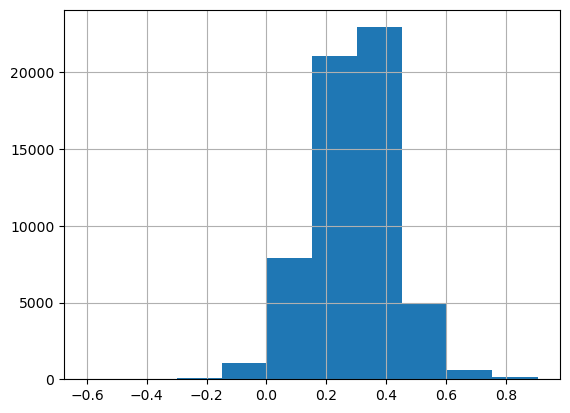

In [109]:
top100_proteins.pearsonR.hist()

### basic analysis

In [73]:
df_conc = df[df.coef_id == 'maxscreeningconc']
sig_conc = df_conc[df_conc['P>|z|'] < 0.05]
conc_counts = sig_conc.drug.value_counts()
# In half the drugs, the dosis has a significant influence on the result in a single protein regression

In [66]:
df_proteins = df[df.coef_id.str.contains('HUMAN')]
df_proteins

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein
2,PdhbaiSRPbeHUMAN,0.344876,0.103,3.350153,0.000913,0.142280,0.547473,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
5,QjgJPfZFPjbHUMAN,0.293598,0.130,2.263659,0.024617,0.037916,0.549281,212,0.023820,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
8,QjYeHcIRScHUMAN,-0.008152,0.200,-0.040702,0.967673,-0.409041,0.392738,60,0.000029,1.511382,1.972468,0.005344,-0.213663,1,60,19,Q9Y4H2.IRS2_HUMAN
11,PdgfhiRLeHUMAN,-0.106366,0.124,-0.860458,0.390235,-0.349647,0.136914,297,0.002504,1.064687,1.881234,0.050035,-0.108920,1,297,79,P36578.RL4_HUMAN
14,QgSPFaSAMDbHUMAN,0.108384,0.073,1.491971,0.136967,-0.034690,0.251458,252,0.008825,0.974873,1.740995,0.093943,0.140308,1,252,71,Q6SPF0.SAMD1_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11457372,QfTAefINTbbHUMAN,-0.232405,0.098,-2.371406,0.018447,-0.425383,-0.039428,263,0.021092,1.094999,1.048937,0.145230,-0.062422,2510,263,63,Q5TA45.INT11_HUMAN
11457375,QhZdBbNEGRbHUMAN,0.041528,0.096,0.431608,0.667477,-0.150687,0.233744,66,0.002902,0.779036,1.743302,0.053873,0.161875,2510,66,12,Q7-73B.1NEGR1_HUMAN
11457378,OgaggjMOTcHUMAN,0.526110,0.340,1.547260,0.131950,-0.167379,1.219599,33,0.071690,1.286882,1.339712,0.267750,-0.047780,2510,33,10,O60669.MOT2_HUMAN
11457381,QbdfhbLAPMfHUMAN,-0.104523,0.395,-0.264885,0.793809,-0.927642,0.718595,22,0.003496,1.843370,1.255639,0.059126,-0.005309,2510,22,11,Q13571.LAPM5_HUMAN


In [74]:
sig_proteins = df_proteins[df_proteins['P>|z|']<0.05]
prot_counts = sig_proteins.drug.value_counts()

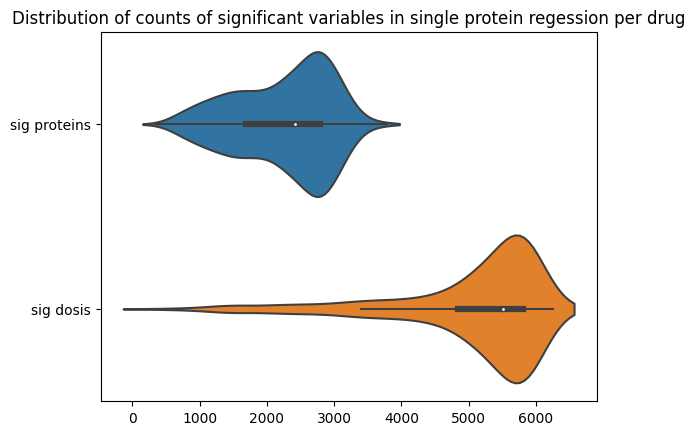

In [78]:
plot = sns.violinplot([prot_counts, conc_counts], cut=True, orient='h' )
plot.set(title='Distribution of counts of significant variables in single protein regession per drug')
plot.set_yticks(range(2))
plot.set_yticklabels(['sig proteins', 'sig dosis'])
plt.show()

In [70]:
sig_proteins[sig_proteins.drug == 1]

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein
2,PdhbaiSRPbeHUMAN,0.344876,0.103,3.350153,0.000913,0.142280,0.547473,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
5,QjgJPfZFPjbHUMAN,0.293598,0.130,2.263659,0.024617,0.037916,0.549281,212,0.023820,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
17,OhgadbCLPXHUMAN,-0.272634,0.136,-2.011889,0.045141,-0.539325,-0.005942,297,0.013535,1.052912,1.926358,0.116341,-0.131889,1,297,79,O76031.CLPX_HUMAN
26,QjPcfiRCCcHUMAN,0.154205,0.060,2.555974,0.011092,0.035469,0.272941,296,0.021738,1.046705,1.802610,0.147438,0.224306,1,296,79,Q9P258.RCC2_HUMAN
32,QgiDKhMSLbHUMAN,0.278303,0.124,2.238358,0.028858,0.029683,0.526924,63,0.075901,0.732984,5.028165,0.275501,-0.296581,1,63,13,Q68DK7.MSL1_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15923,QjNYRjKBRScHUMAN,0.344464,0.102,3.369227,0.001345,0.139812,0.549117,60,0.163683,0.290699,0.640816,0.404578,0.396037,1,60,9,Q9NYR9.KBRS2_HUMAN
15965,QjNPfaSHCAFHUMAN,0.211151,0.099,2.126712,0.036035,0.014045,0.408256,97,0.045446,0.625095,1.036760,0.213180,0.134718,1,97,22,Q9NP50.SHCAF_HUMAN
16016,AgNCjiCCiiBHUMAN,0.904205,0.236,3.827147,0.000771,0.417617,1.390793,27,0.369436,0.827432,1.458424,0.607813,0.150571,1,27,10,A6NC98.CC88B_HUMAN
16019,QjUBKjUXTHUMAN,0.341796,0.118,2.893053,0.005081,0.106166,0.577426,72,0.106798,0.629218,0.780104,0.326800,0.048992,1,72,25,Q9UBK9.UXT_HUMAN


In [57]:
pearsonR = pd.pivot_table(df, values='pearsonR', index=['drug'], columns=['protein'], aggfunc=np.mean, fill_value=0)

<Axes: ylabel='Frequency'>

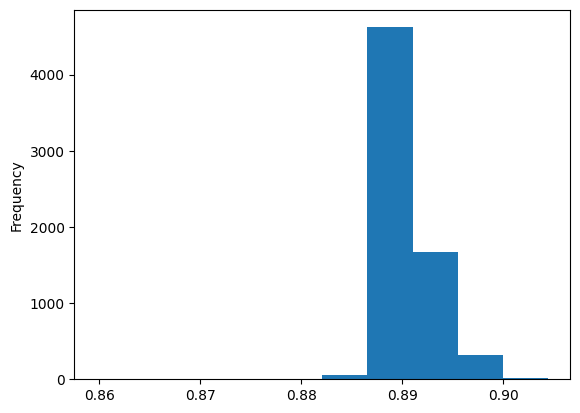

In [59]:
pearsonR.max(axis=0).plot.hist()

In [37]:
df[(df.drug==1)]

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test,protein
0,Intercept,0.045401,0.139,0.327307,7.436675e-01,-0.227587,0.318389,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
1,maxscreeningconc,0.090802,0.277,0.327307,7.436675e-01,-0.455174,0.636779,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
2,PdhbaiSRPbeHUMAN,0.344876,0.103,3.350153,9.127479e-04,0.142280,0.547473,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79,P37108.SRP14_HUMAN
3,Intercept,0.312031,0.094,3.323116,1.050116e-03,0.126929,0.497132,212,0.023820,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
4,maxscreeningconc,0.624062,0.188,3.323116,1.050116e-03,0.253858,0.994265,212,0.023820,1.024769,2.191084,0.154336,-0.084071,1,212,63,Q96JP5.-7FP91_HUMAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16095,Intercept,0.613268,0.234,2.623360,1.588114e-02,0.127113,1.099423,23,0.024828,1.286461,1.369504,0.157567,-0.240216,1,23,11,Q13571.LAPM5_HUMAN
16096,maxscreeningconc,1.226535,0.468,2.623360,1.588114e-02,0.254225,2.198845,23,0.024828,1.286461,1.369504,0.157567,-0.240216,1,23,11,Q13571.LAPM5_HUMAN
16097,QbdfhbLAPMfHUMAN,-0.241349,0.330,-0.731199,4.727384e-01,-0.927772,0.445075,23,0.024828,1.286461,1.369504,0.157567,-0.240216,1,23,11,Q13571.LAPM5_HUMAN
16098,Intercept,0.508417,0.012,42.333167,1.339536e-127,0.484782,0.532053,297,0.000000,1.067359,1.869774,NaN,NaN,1,297,79,DOSIS.


In [18]:
performance = df[['pearsonR', 'MSE', 'drug', 'protein']].drop_duplicates(ignore_index=True)

In [19]:
performance['group'] = performance.protein == 'DOSIS.'

In [30]:
performance[~performance.group].dropna()

,pearsonR,MSE,drug,protein,group
0,0.050281,1.867878,1,P37108.SRP14_HUMAN,False
1,-0.084071,2.191084,1,Q96JP5.-7FP91_HUMAN,False
2,-0.213663,1.972468,1,Q9Y4H2.IRS2_HUMAN,False
3,-0.108920,1.881234,1,P36578.RL4_HUMAN,False
4,0.140308,1.740995,1,Q6SPF0.SAMD1_HUMAN,False
...,...,...,...,...,...
3819340,-0.062422,1.048937,2510,Q5TA45.INT11_HUMAN,False
3819341,0.161875,1.743302,2510,Q7-73B.1NEGR1_HUMAN,False
3819342,-0.047780,1.339712,2510,O60669.MOT2_HUMAN,False
3819343,-0.005309,1.255639,2510,Q13571.LAPM5_HUMAN,False


In [36]:
baseline = performance[performance.group]
baseline

,pearsonR,MSE,drug,protein,group
5366,NaN,1.869774,1,DOSIS.,True
10588,NaN,4.714342,3,DOSIS.,True
15965,NaN,3.085074,5,DOSIS.,True
21354,NaN,0.599534,6,DOSIS.,True
26711,NaN,2.227019,9,DOSIS.,True
...,...,...,...,...,...
3795992,NaN,1.143818,2504,DOSIS.,True
3801816,NaN,5.318066,2505,DOSIS.,True
3807657,NaN,7.409905,2508,DOSIS.,True
3813504,NaN,3.046614,2509,DOSIS.,True


In [54]:
drugs_with_2 = baseline.dropna().drug.unique()
drugs_with_2
mask = [d in drugs_with_2 for d in performance.drug]
with_baseline = performance[mask]

In [59]:
with_baseline.dropna()

,pearsonR,MSE,drug,protein,group
1290189,0.229819,2.385504,1005,P37108.SRP14_HUMAN,False
1290190,0.242908,2.197911,1005,Q96JP5.-7FP91_HUMAN,False
1290191,0.110185,2.802077,1005,Q9Y4H2.IRS2_HUMAN,False
1290192,0.317409,2.252200,1005,P36578.RL4_HUMAN,False
1290193,0.240209,2.384350,1005,Q6SPF0.SAMD1_HUMAN,False
...,...,...,...,...,...
2402815,0.317518,5.200910,1529,Q7-73B.1NEGR1_HUMAN,False
2402816,0.474059,4.488082,1529,O60669.MOT2_HUMAN,False
2402817,0.173176,1.308127,1529,Q13571.LAPM5_HUMAN,False
2402818,0.258435,2.489758,1529,Q96JM2.-7N462_HUMAN,False


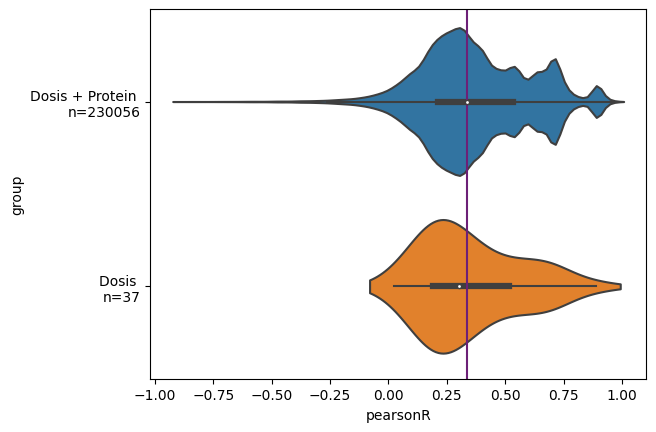

In [63]:
plot = sns.violinplot(with_baseline, x='pearsonR', y='group', orient='h', cut=True)
plt.axvline(with_baseline.pearsonR.median(), 0, c="#6D2077")
plot.set_yticks(range(2))
plot.set_yticklabels([f'Dosis + Protein \nn={with_baseline.shape[0]}', 'Dosis \nn=37'])
plt.show()

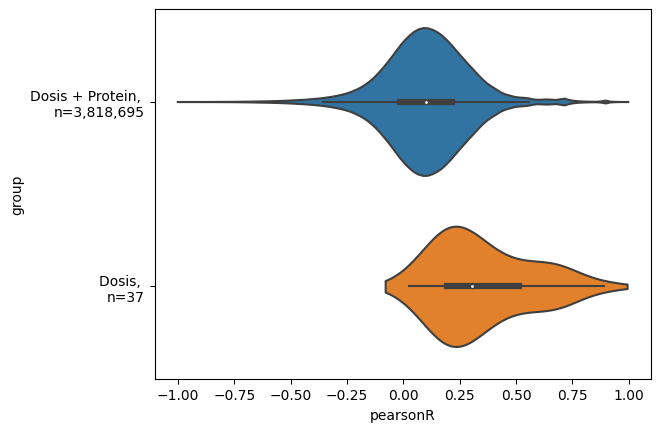

In [35]:
plot = sns.violinplot(performance, x='pearsonR', y='group', orient='h', cut=True)
plot.set_yticks(range(2))
plot.set_yticklabels(['Dosis + Protein, \nn=3,818,695', 'Dosis, \nn=37'])
plt.show()

In [7]:
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'
y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]

C:\Users\wen068\AppData\Local\Temp\ipykernel_15244\1923757283.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]


<Axes: xlabel='ln_IC50', ylabel='max_screening_conc'>

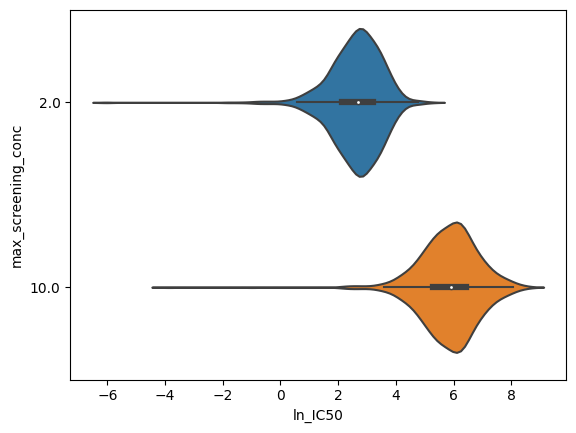

In [11]:
sns.violinplot(y[y.drug_id==1029], x='ln_IC50', y ='max_screening_conc', orient='h')

<Axes: ylabel='Frequency'>

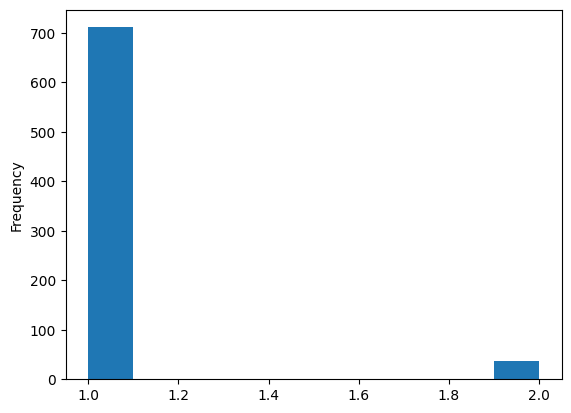

In [51]:
y[['drug_id', 'max_screening_conc']].drop_duplicates().drug_id.value_counts().plot.hist()

### Regression test code

In [2]:
working_dir = 'tmp/'

# File inputs
# x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x_input = 'data/train_protein_matrix.csv'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

test_input = 'data/test_protein_matrix.csv'


In [3]:
x = pd.read_csv(x_input)
c = [a.replace('.','').replace('_','') for a in x.columns]
x.columns = c

x_test = pd.read_csv(test_input)
x_test.columns = c

y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]

C:\Users\wen068\AppData\Local\Temp\ipykernel_10264\2547150521.py:8: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]


In [4]:
drug_list = np.unique(y.drug_id)
protein_list = c[1:]

In [5]:
def results_fit_to_df(results, ols, y, test_data):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    # adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    pred_y = results.predict()
    train_pear_R = pearsonr(pred_y, y).statistic
    train_mse = np.square(y - pred_y).mean()

    if len(test_data.ln_IC50) < 8:
        test_pear_R = None
        test_mse = None
    else:    
        test_y = test_data.ln_IC50.to_list()
        pred_y = results.predict(test_data)
        test_pear_R = pearsonr(pred_y, test_y).statistic   # want 20 entries for this
        test_mse = np.square(test_y - pred_y).mean()

    
    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    # results['adj_r2'] = adj_r2
    results["train_MSE"] = train_mse
    results["MSE"] = test_mse
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    results["train_pearsonR"] = train_pear_R
    results["pearsonR"] = test_pear_R
    return results

In [23]:
regression_results = []
for d in drug_list[:1]:
    print(f'currently looking at drug {d}')
    c = 0
    xy = x.merge(y[y["drug_id"]==d], left_on='CellLine', right_on='cell_line_name')
    test_xy = x_test.merge(y[y["drug_id"] == d], left_on='CellLine', right_on='cell_line_name')
    for p in protein_list:

        
        data = xy[["ln_IC50", "max_screening_conc", p]].dropna()
        test_data = test_xy[["ln_IC50", "max_screening_conc", p]].dropna()

        # print(f'For drug {d} and {p} there are {len(data[p])} and {len(test_data[p])} cell lines')

        if len(test_data[p]) < 8:
            # print(f'Not enough test cell lines for protein {p} and drug {d}, n = {len(test_data[p])}')
            c += 1
            continue

        formula = "ln_IC50 ~ max_screening_conc + " + p
        ols = smf.ols(formula,data=data)
        results = ols.fit(disp=False, maxiter=1000)
        results = results_fit_to_df(results, ols, data["ln_IC50"].to_list(), test_data)
        results["drug"] = d
        results["n_train"] = len(data[p])
        results["n_test"] = len(test_data[p])
        regression_results.append(results.loc[[2]])
        del data, test_data   
    print(f'For {c} proteins we did not have enough data')
    del xy, test_xy
regression_results = pd.concat(regression_results)

currently looking at drug 1


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by

For 1326 proteins we did not have enough data


In [22]:
1.5*949/60

23.725

In [18]:
regression_results

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug,n_train,n_test
2,P37108SRP14HUMAN,0.344876,0.103,3.350153,0.000913,0.142280,0.547473,297,0.036651,1.028239,1.867878,0.191446,0.050281,1,297,79
2,Q96JP5ZFP91HUMAN,0.293598,0.130,2.263659,0.024617,0.037916,0.549281,212,0.023820,1.024769,2.191084,0.154336,-0.084071,1,212,63
2,Q9Y4H2IRS2HUMAN,-0.008152,0.200,-0.040702,0.967673,-0.409041,0.392738,60,0.000029,1.511382,1.972468,0.005344,-0.213663,1,60,19
2,P36578RL4HUMAN,-0.106366,0.124,-0.860458,0.390235,-0.349647,0.136914,297,0.002504,1.064687,1.881234,0.050035,-0.108920,1,297,79
2,Q6SPF0SAMD1HUMAN,0.108384,0.073,1.491971,0.136967,-0.034690,0.251458,252,0.008825,0.974873,1.740995,0.093943,0.140308,1,252,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Q96RT7GCP6HUMAN,-0.009340,0.174,-0.053654,0.957555,-0.364363,0.345683,33,0.000093,0.604705,0.390081,0.009636,-0.155726,1,33,11
2,Q86SZ2TPC6BHUMAN,0.329737,0.213,1.547722,0.126331,-0.095391,0.754866,70,0.034028,1.068815,3.837595,0.184468,0.018681,1,70,17
2,Q5EBL4RIPL1HUMAN,0.013412,0.143,0.093868,0.925589,-0.273580,0.300404,52,0.000176,0.664233,0.957161,0.013274,-0.229536,1,52,17
2,Q5TA45INT11HUMAN,-0.119480,0.120,-0.997674,0.319944,-0.355992,0.117031,162,0.006183,1.185055,1.522771,0.078629,0.100663,1,162,37


In [45]:
regression_results.to_csv("protein_regression.csv", index=False)

pd.pivot_table(regression_results, values='pearsonR', index=['drug'], columns=['coef_id'], aggfunc=np.sum, fill_value=0).to_csv("protein_regression_pearsonR.csv")

,coef_id,coef,std err,z,P>|z|,[0.025,0.975],converged,pseudo_r2,adj_r2,train_MSE,MSE,train_pearsonR,pearsonR,drug
2,P37108SRP14HUMAN,0.344876,0.103,3.350153,0.000913,0.142280,0.547473,297,3.665141e-02,0.033386,1.028239,1.867878,0.191446,0.050281,1
2,Q96JP5ZFP91HUMAN,0.083934,0.035,2.367290,0.018564,0.014156,0.153712,297,1.864266e-02,0.015316,1.047461,1.920604,0.136538,-0.077095,1
2,Q9Y4H2IRS2HUMAN,-0.048480,0.055,-0.883640,0.377612,-0.156455,0.059496,297,2.648817e-03,-0.004136,1.064532,1.881244,0.051467,-0.056817,1
2,P36578RL4HUMAN,-0.106366,0.124,-0.860458,0.390235,-0.349647,0.136914,297,2.503509e-03,-0.000878,1.064687,1.881234,0.050035,-0.108920,1
2,Q6SPF0SAMD1HUMAN,0.083535,0.040,2.105337,0.036107,0.005448,0.161623,297,1.480281e-02,0.011463,1.051559,1.857387,0.121667,0.086719,1
2,O76031CLPXHUMAN,-0.272634,0.136,-2.011889,0.045141,-0.539325,-0.005942,297,1.353529e-02,0.010191,1.052912,1.926358,0.116341,-0.131889,1
2,Q8WUQ7CATINHUMAN,0.167690,0.244,0.687954,0.492024,-0.312029,0.647409,297,1.607213e-03,-0.005185,1.065644,1.859011,0.040090,0.109621,1
2,A6NIH7U119BHUMAN,0.064529,0.045,1.427413,0.154519,-0.024440,0.153498,297,6.859431e-03,0.003493,1.060038,1.860427,0.082822,0.071958,1
2,Q9BTD8RBM42HUMAN,0.057629,0.071,0.807258,0.420168,-0.082866,0.198123,297,2.204167e-03,-0.001178,1.065006,1.871115,0.046949,-0.024887,1
2,Q9P258RCC2HUMAN,0.129715,0.057,2.260317,0.024530,0.016773,0.242657,297,1.702392e-02,0.013692,1.049188,1.812365,0.130476,0.224306,1


In [38]:
xy = x.merge(y[y["drug_id"]==3], left_on='CellLine', right_on='cell_line_name')
test_xy = x_test.merge(y[y["drug_id"] == 1], left_on='CellLine', right_on='cell_line_name')

data = xy[["ln_IC50", "max_screening_conc", 'P37108SRP14HUMAN']].dropna()
test_data = test_xy[["ln_IC50", "max_screening_conc", 'P37108SRP14HUMAN']].dropna()

# print(f'For drug {d} and {p} there are {len(data[p])} and {len(test_data[p])} cell lines')


formula = "ln_IC50 ~ max_screening_conc"
ols = smf.ols(formula,data=data)
results = ols.fit(disp=False, maxiter=1000)

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_IC50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 16 Aug 2023   Prob (F-statistic):                nan
Time:                        15:33:58   Log-Likelihood:                -563.77
No. Observations:                 268   AIC:                             1130.
Df Residuals:                     267   BIC:                             1133.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.1651      0.120    -18.018      0.000      -2.402      -1.929
max_screening_conc    -0.2165      0.012    -18.018      0.000      -0.240      -0.193
==============================================================================
Omnibus:                       48.714   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.518
Skew:                          -1.098   Prob(JB):                     1.79e-16
Kurtosis:                       4.295   Cond. No.                     2.11e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.09e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [44]:
results.predict(test_data)

0    -2.59817
1    -2.59817
2    -2.59817
3    -2.59817
4    -2.59817
       ...   
74   -2.59817
75   -2.59817
76   -2.59817
77   -2.59817
78   -2.59817
Length: 79, dtype: float64

In [45]:
set(data.max_screening_conc)

{0.1}